# Image Classification Data (Fashion-MNIST)

Before we implement softmax regression ourselves, let's pick a real dataset to work with. To make things visually compelling, we will pick an image classification dataset. The most commonly used image classification data set is the [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit recognition data set, proposed by LeCun, Cortes and Burges in the 1990s. However, even simple models achieve classification accuracy over 95% on MNIST, so it is hard to spot the differences between better models and weaker ones. In order to get a better intuition, we will use the qualitatively similar, but comparatively complex [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, proposed by [Xiao, Rasul and Vollgraf](https://arxiv.org/abs/1708.07747) in 2017.

## Getting the Data

First, import the packages or modules required in this section.



In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '..')
import d2l

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import time

Conveniently, PyTorch's `torchvision.datasets` package provides easy access to a number of benchmark vision datasets for testing our models.
The first time we invoke `data.vision.FashionMNIST(train=True)`
to collect the training data,
PyTorch will automatically retrieve the dataset via our Internet connection.
Subsequently, PyTorch will use the already-downloaded local copy.
We specify whether we are requesting the training set or the test set
by setting the value of the parameter `train` to `True` or `False`, respectively.
Recall that we will only be using the training data for training,
holding out the test set for a final evaluation of our model.

In [2]:
# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = transforms.ToTensor() 

The `ToTensor` Transform also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations introduced later.

In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/home/jeon/anaconda3/envs/ai_safe/lib/python3.6/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The number of images for each category in the training set and the testing set is 6,000 and 1,000, respectively. Since there are 10 categories, the numbers of examples in the training set and the test set are 60,000 and 10,000, respectively.

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

We can access any example by indexing into the dataset using square brackets `[]`. In the following code, we access the image and label corresponding to the first example.

In [5]:
feature, label = mnist_train[0]

Our example, stored here in the variable `feature` corresponds to an image with a height and width of 28 pixels. PyTorch automatically scales it into a tensor with each pixel value between 0 and 1. It is stored in a 3D Tensor. Its first dimension is the number of channels. Since the data set is a grayscale image, the number of channels is 1. When we encounter color, images, we'll have 3 channels for red, green, and blue. To keep things simple, we will record the shape of the image with the height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.

In [6]:
feature.shape, feature.dtype

(torch.Size([1, 28, 28]), torch.float32)

The label of each image is represented as a scalar in PyTorch. Its type is a 64-bit integer.

In [8]:
label, type(label)

(9, int)

There are 10 categories in Fashion-MNIST: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. The following function can convert a numeric label into a corresponding text label.

In [9]:
# This function has been saved in the d2l package for future use
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

The following defines a function that can draw multiple images and corresponding labels in a single line.

In [10]:
# This function has been saved in the d2l package for future use
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # Here _ means that we ignore (not use) variables
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

Next, let's take a look at the image contents and text labels for the first nine examples in the training data set.

Note: PyTorch DataLoader objects don't support regular array slicing. You can instead iterate through.

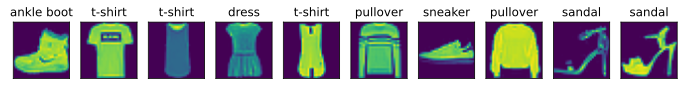

In [11]:
X=[]
y=[]
for idx, data in enumerate(mnist_train):
    if(idx>=0 and idx<10):
        X.append(data[0])
        y.append(data[1])
    if (idx>=10):
        break
# X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## Reading a Minibatch

To make our life easier when reading from the training and test sets we use a `DataLoader` rather than creating one from scratch, as we did in `chapter_linear_scratch`. Recall that a data loader reads a mini-batch of data with an example number of `batch_size` each time.

In practice, reading data can often be a significant performance bottleneck for training, especially when the model is simple or when the computer is fast. A handy feature of PyTorch's `DataLoader` is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via `num_workers`).

We've already applied required transformations before.

In [12]:
batch_size = 256
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

The logic that we will use to obtain and read the Fashion-MNIST data set is
encapsulated in the `d2l.load_data_fashion_mnist` function, which we will use in
later chapters. This function will return two variables, `train_iter` and
`test_iter`. As the content of this book continues to deepen, we will further
improve this function.

Let's look at the time it takes to read the training data.

In [13]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'0.99 sec'

## Summary

* Fashion-MNIST is an apparel classification data set containing 10 categories, which we will use to test the performance of different algorithms in later chapters.
* We store the shape of image using height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.
* Data iterators are a key component for efficient performance. Use existing ones if available.

## Exercises

1. Does reducing `batch_size` (for instance, to 1) affect read performance?
1. For non-Windows users, try modifying `num_workers` to see how it affects read performance.
1. Use the PyTorch documentation to see which other datasets are available in `torchvision.datasets`.
1. Use the PyTorch documentation to see which other transformations are available in `torchvision.transforms`.